In [1]:
import os

import itertools
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn

from shapely.geometry import Point
import jismesh.utils as ju

import pyproj

In [2]:
def parse_time(timestamp):
    hour = timestamp // 3600
    minute = (timestamp % 3600) // 60
    seconds = (timestamp % 3600) % 60
    return hour, minute, seconds

def Coordinate2MeshCodePandas(lon, lat, level):

    return ju.to_meshcode(lat, lon, level).astype(int).astype(str)

from math import radians, cos, sin, asin, sqrt, ceil, log


R = 6371


def haversine(lon1, lat1, lon2, lat2):
    # UNIT: KILOMETER

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))

    return c * R

def mesh_distance(mesh_1, mesh_2):
    """

    :param mesh_1:
    :param mesh_2:
    :return:
    """
    lat1, lon1 = ju.to_meshpoint(mesh_1, 0.5, 0.5)
    lat2, lon2 = ju.to_meshpoint(mesh_2, 0.5, 0.5)

    return haversine(lon1, lat1, lon2, lat2)

def mesh_distance_df(row):
    return mesh_distance(row['origin_agg_key_cd'], row['destination_agg_key_cd'])

In [3]:
def mesh_pair_distance(m1, m2):
    """
    Return distance for central point of m1 and m2
    Args:
        m1: mesh id of m1
        m2: mesh id of m2
    Returns:
        d: distance
    """
    m1_lat, m1_lon = ju.to_meshpoint(m1, lat_multiplier=0.5, lon_multiplier=0.5)
    m2_lat, m2_lon = ju.to_meshpoint(m2, lat_multiplier=0.5, lon_multiplier=0.5)
    geodesic = pyproj.Geod(ellps='WGS84')
    faz, baz, d = geodesic.inv(m1_lon, m1_lat, m2_lon, m2_lat)
    d /= 1000.0
    return d

In [4]:
def calculate_mape(row):
    epsilon = 1e-8  
    seq1 = row[[f'vol_{i}_obs' for i in range(5, 24)]].values
    seq2 = row[[f'vol_{i}_ppf' for i in range(5, 24)]].values
    mape = np.mean(np.abs((seq1 - seq2) / (seq1 + epsilon))) * 100
    return mape

In [5]:
# toyama = pd.read_csv('/mnt/large/data/Softbank/21015_toyama_od_meshod_500m_daily.txt', encoding='shift-jis')
toyama = pd.read_csv('C://large/Softbank/21015_toyama_od_meshod_500m_daily.txt', encoding='shift-jis')
toyama = toyama.drop([len(toyama)-1], axis=0)
toyama = toyama.astype({'dt': 'str','mesh_cd': 'int64', 'od_class': 'int8', 'trip_class': 'int8', 'origin_agg_key_cd': 'int64', 'destination_agg_key_cd': 'int64', 'main_mode': 'int8' })

# shizuoka = pd.read_csv('/mnt/large/data/Softbank/21015_shizuoka_od_meshod_500m_daily.txt', names=toyama.columns, encoding='shift-jis')
shizuoka = pd.read_csv('C://large/Softbank/21015_shizuoka_od_meshod_500m_daily.txt', names=toyama.columns, encoding='shift-jis')
shizuoka = shizuoka.drop([len(shizuoka)-1], axis=0)
shizuoka = shizuoka.astype({'dt': 'str','mesh_cd': 'int64', 'od_class': 'int8', 'trip_class': 'int8', 'origin_agg_key_cd': 'int64', 'destination_agg_key_cd': 'int64', 'main_mode': 'int8' })

C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_13340\2672372256.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  toyama = pd.read_csv('C://large/Softbank/21015_toyama_od_meshod_500m_daily.txt', encoding='shift-jis')


## daily coverage

In [ ]:
for group in shizuoka.groupby("dt"):
    # group[1].to_csv('/home/ubuntu/Data/SoftbankOD/shizuoka_'+group[0]+'_od_meshod_500m_daily.csv', index=False)
    group[1].to_csv('C://large/Softbank/shizuoka_'+group[0]+'_od_meshod_500m_daily.csv', index=False)

In [ ]:
shizuoka = shizuoka.replace('＊', 1)
shizuoka = shizuoka.astype({'total_people': 'float'})

In [ ]:
shizuoka = shizuoka[shizuoka["od_class"]==2]
shizuoka = shizuoka[shizuoka["trip_class"]==2]

In [ ]:
shizuoka['origin_mesh_lv3'] = shizuoka['origin_agg_key_name'].astype(float) / 10
shizuoka['origin_mesh_lv3'] = shizuoka['origin_mesh_lv3'].astype(int)
shizuoka['destination_mesh_lv3'] = shizuoka['destination_agg_key_name'].astype(float) / 10
shizuoka['destination_mesh_lv3'] = shizuoka['destination_mesh_lv3'].astype(int)
shizuoka

In [ ]:
shizuoka_lv3 = {}
idx = 0

for group in shizuoka.groupby(['dt', 'origin_mesh_lv3', 'destination_mesh_lv3']):

    dt = group[1]['dt'].tolist()[0]
    pref_name = group[1]['pref_name'].tolist()[0]
    city_name = group[1]['city_name'].tolist()[0]
    mesh_cd = group[1]['mesh_cd'].tolist()[0]
    od_class = group[1]['od_class'].tolist()[0]
    trip_class = group[1]['trip_class'].tolist()[0]
    origin_agg_key_cd = group[1]['origin_mesh_lv3'].tolist()[0]
    origin_agg_key_name = group[1]['origin_mesh_lv3'].tolist()[0]
    destination_agg_key_cd = group[1]['destination_mesh_lv3'].tolist()[0]
    destination_agg_key_name = group[1]['destination_mesh_lv3'].tolist()[0]
    total_people = sum(group[1]['total_people'].tolist())
#     {'dt':dt, 'pref_name':pref_name, 'city_name':city_name, 'mesh_cd':mesh_cd, 'od_class': od_class, 'trip_class': trip_class,
#                                        'origin_agg_key_cd':origin_agg_key_cd, 'origin_agg_key_name':origin_agg_key_name, 'destination_agg_key_cd':destination_agg_key_cd,
#                                        'destination_agg_key_name': destination_agg_key_name, 'total_people':total_people})
    shizuoka_lv3[idx] = [dt, pref_name, city_name, mesh_cd, od_class, trip_class, origin_agg_key_cd, origin_agg_key_name, destination_agg_key_cd, destination_agg_key_name, total_people]
    idx += 1
    if idx % 10000 == 0:
        print(idx)

# shizuoka_lv3

In [ ]:
# 使用 groupby 和 agg 进行简化
shizuoka_lv3_df = (
    shizuoka.groupby(['dt', 'origin_mesh_lv3', 'destination_mesh_lv3'], as_index=False)
    .agg(
        pref_name=('pref_name', 'first'),
        city_name=('city_name', 'first'),
        mesh_cd=('mesh_cd', 'first'),
        od_class=('od_class', 'first'),
        trip_class=('trip_class', 'first'),
        origin_agg_key_cd=('origin_mesh_lv3', 'first'),
        origin_agg_key_name=('origin_mesh_lv3', 'first'),
        destination_agg_key_cd=('destination_mesh_lv3', 'first'),
        destination_agg_key_name=('destination_mesh_lv3', 'first'),
        total_people=('total_people', 'sum')
    )
)

shizuoka_lv3_df.reset_index(drop=True, inplace=True)

shizuoka_lv3_df

In [ ]:
shizuoka_lv3_df['total_people'].hist(bins=100)

In [ ]:
df = pd.DataFrame.from_dict(shizuoka_lv3, orient='index', columns=['dt', 'pref_name', 'city_name', 'mesh_cd', 'od_class', 'trip_class', 'origin_agg_key_cd', 'origin_agg_key_name', 'destination_agg_key_cd', 'destination_agg_key_name', 'total_people'])
df.to_csv('C://large/Softbank/shizuoka_OD_mesh_lv3.csv', index=False)

In [ ]:
date = ['20191013', '20191014', '20191015', '20191016', '20191017', '20191018', '20191019',
        '20201011', '20201012', '20201013', '20201014', '20201015', '20201016', '20201017']

In [ ]:
shizuoka = shizuoka.replace('＊', 5)
shizuoka = shizuoka.astype({'total_people': 'float'})

In [ ]:
mesh = gpd.read_file('/home/ubuntu/Data/shapefile/shizuoka500mesh/500m_mesh_2018_22.shp')
mesh[['MESH_ID', 'SHICODE', 'PTN_2015', 'geometry']]
# mesh.columns
mesh_shicode ={}
for idx, row in mesh.iterrows():
    if row['MESH_ID'] not in mesh_shicode:
        mesh_shicode[row['MESH_ID']] = row['SHICODE']

In [ ]:
code = pd.DataFrame.from_dict(mesh_shicode, orient='index').reset_index().rename(columns={'index': 'origin_agg_key_cd', 0: 'shicode'})

In [ ]:
shizuoka_day = shizuoka[shizuoka['dt']=='20191013']
shizuoka_day

In [ ]:
data = shizuoka_day[shizuoka_day['city_name'].isin(['静岡市 駿河区', '静岡市 葵区', '富士市', '浜松市 中区', '沼津市', '裾野市'])]
data = data[data['od_class']==2]
data = data[data['trip_class']==2]
data

In [ ]:
data['dist'] = data.apply(mesh_distance_df, axis=1)

In [ ]:
data

In [ ]:
mesh_pair_distance(523705271, 523705281	)

In [ ]:
data[data['total_people']>1].plot.scatter(x='dist', y='total_people',s=1, figsize=(12,8))

In [ ]:
data['dist'].hist()

In [ ]:
data['total_people'].max()

In [ ]:
shizuoka_day['city_name'].unique()

In [ ]:
len(data[data['city_name']== '富士市'])*0.8

In [ ]:
data[data['city_name']=='静岡市 葵区']['total_people'].hist(range=(400,14000),bins=400)

In [ ]:
data[data['city_name']=='富士市']['total_people'].hist(range=(400,14000),bins=400)

In [ ]:
data[data['city_name']=='静岡市 駿河区']['total_people'].hist(range=(400,14000),bins=400)

In [ ]:
data[data['city_name']=='沼津市']['total_people'].hist(range=(500,14000),bins=400)

In [ ]:
data[data['city_name']=='浜松市 中区']['total_people'].hist(range=(400,14000),bins=400)

In [ ]:
data[data['city_name']=='裾野市']['total_people'].hist(range=(100,14000),bins=400)

In [ ]:
shizuoka_day = pd.merge(shizuoka_day, code, how='left').rename(columns={'shicode': 'origin_shicode'})
# set(shizuoka_day['origin_shicode'].tolist())

In [ ]:
code = code.rename(columns={'origin_agg_key_cd': 'destination_agg_key_cd'})
shizuoka = pd.merge(shizuoka, code, on='destination_agg_key_cd').rename(columns={'shicode': 'destination_shicode'})

In [ ]:
shizuoka = shizuoka[['dt', 'pref_name', 'city_name', 'mesh_cd', 'od_class', 'trip_class',
       'origin_agg_key_cd', 'origin_shicode', 'destination_agg_key_cd',
       'destination_shicode', 'main_mode', 'total_people']]

In [ ]:
shizuoka_day[shizuoka_day['origin_shicode']==22101]['destination_shicode'].tolist()

In [ ]:
for group in shizuoka_day.groupby(['origin_shicode', 'destination_shicode']):
    print(group[0])
    #print(group[1])
    #print(sum(group[1]['total_people']))
    #break

In [ ]:
len(shizuoka_day.groupby(['origin_shicode', 'destination_shicode']))

## Classification

In [ ]:
data = od[['trip_class', 'origin_agg_key_cd', 'destination_agg_key_cd', 'main_mode', 'total_people']]
data = data[data['trip_class'].isin([1, 2])]
data = data.drop(['trip_class'], axis=1)
data = data.reset_index(drop=True)

In [ ]:
locs = list(set(data['destination_agg_key_cd'].tolist()+data['origin_agg_key_cd'].tolist()))

In [ ]:
len(data) / count

In [ ]:
for group in data.groupby('origin_agg_key_cd'):
    print(len(group[1]))

In [ ]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ToyamaZone/N03-20210101_16_GML/N03-21_16_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

idx = 0
od_volume = {}

path = '/home/ubuntu/Data/pflow/pseudo/trip/Toyama/'

for f in os.listdir(path):
    if f.endswith('.zip'):
        print(f)
        pseudo_od_counter(os.path.join(path, f), zones, od_volume)

In [ ]:
od_volume

In [ ]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ShizuokaZone/N03-20210101_22_GML/N03-21_22_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

idx = 0
od_volume = {}

path = '/home/ubuntu/Data/pflow/Shizuoka/p-csv/'

for d in os.listdir(path):
    for root, ds, fs in os.walk(path + d):
        print(root)
        for f in fs:
            if f.endswith('.csv'):
                od_counter(os.path.join(root, f), zones, od_volume)

In [ ]:
shizuoka = pd.DataFrame.from_dict(od_volume, orient='index').reset_index().rename(columns={'index':'od', 0:'volume'})
shizuoka['origin'], shizuoka['destination'] = shizuoka.od.str
shizuoka = shizuoka[['origin', 'destination', 'volume']]
shizuoka.to_csv('Softbank/Shizuoka_pt_zone_od.csv', index=False)

## Shizuoka Pseudo PFLOW

In [6]:
# Not regenerate LV3 observation df
shizuoka_lv3_df = pd.read_csv('C://large/Softbank/shizuoka_OD_mesh_lv3.csv')
shizuoka_lv3_df

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,total_people
0,20191013,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,51377598,51377598,2.0
1,20191013,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,51377599,51377599,69.6
2,20191013,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,52370508,52370508,1.0
3,20191013,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,52370509,52370509,98.9
4,20191013,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,52370518,52370518,30.3
...,...,...,...,...,...,...,...,...,...,...,...
1610489,20201017,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380738,53380738,1.0
1610490,20201017,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380739,53380739,1.0
1610491,20201017,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380749,53380749,1.0
1610492,20201017,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380778,53380778,1.0


In [7]:
# root = '/mnt/large/data/PseudoPFLOW/ver2.0/trip/22/'
# root = "C:/Data/PseudoPFLOW/trip/22/"
root = "C:/log/baseline(beta=2.0)/trip/"
# names = [baseline(beta=2.0), beta0.1, beta1.0, beta4.0, city_t_0.001, city_t_1000, facility_t_0.001, mesh_t_0.001, mesh_t_1000
shizuoka = []

for filename in os.listdir(root):
    # print(filename)
    df = pd.read_csv(root+filename, names=['pid', 'time', 'origin_lon', 'origin_lat', 'destn_lon', 'destn_lat', 'transport', 'puropse', 'occupation'])
    df['origin_mesh'] = Coordinate2MeshCodePandas(df['origin_lon'], df['origin_lat'], 3)
    df['destn_mesh'] = Coordinate2MeshCodePandas(df['destn_lon'], df['destn_lat'], 3)
    shizuoka.append(df)
    
shizuoka = pd.concat(shizuoka, axis=0)
shizuoka

,pid,time,origin_lon,origin_lat,destn_lon,destn_lat,transport,puropse,occupation,origin_mesh,destn_mesh
0,66218309,26775,138.416206,35.001436,138.423146,35.007683,2,2,21,52384303,52384303
1,66218309,27651,138.423146,35.007683,138.435983,35.014404,3,400,21,52384303,52384314
2,66218309,30267,138.435983,35.014404,138.423146,35.007683,2,2,21,52384314,52384303
3,66218309,65475,138.423146,35.007683,138.416206,35.001436,2,1,21,52384303,52384303
4,66218313,24525,138.410979,35.003842,138.495963,35.040423,3,2,21,52384302,52384349
...,...,...,...,...,...,...,...,...,...,...,...
50593,69852377,55240,137.901238,34.815303,137.929741,34.830650,3,1,13,52371772,52371794
50594,69852387,25456,137.932779,34.834391,137.901238,34.815303,3,3,13,52372704,52371772
50595,69852387,52456,137.901238,34.815303,137.932779,34.834391,3,1,13,52371772,52372704
50596,69852401,24147,137.932059,34.833128,137.961179,34.738314,3,3,15,52371794,52370786


In [8]:
len(shizuoka.pid.unique())

3388951

<Axes: >

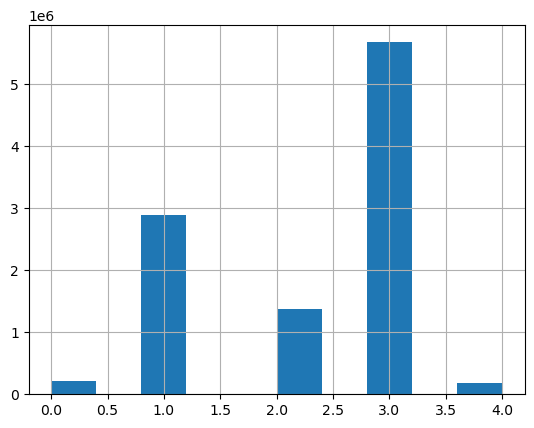

In [9]:
shizuoka['transport'].hist()

In [10]:
shizuoka_pseudo = dict()
idx = 0
for group in shizuoka.groupby(['origin_mesh', 'destn_mesh']):
    shizuoka_pseudo[idx] = [group[0][0], group[0][1], len(group[1])]
    idx += 1
shizuoka_pseudo = pd.DataFrame.from_dict(shizuoka_pseudo, orient='index')
shizuoka_pseudo.columns = ['origin', 'destination', 'volume']
shizuoka_pseudo

,origin,destination,volume
0,51364760,51365731,1
1,51365585,51365595,1
2,51365587,51365588,3
3,51365587,52370520,1
4,51365587,52371464,2
...,...,...,...
719860,54390330,52387765,1
719861,54392139,54392148,2
719862,54392148,52387798,1
719863,54392148,53380739,1


In [11]:
shizuoka_pseudo['volume'].value_counts()

volume
1       342089
2       108211
3        54179
4        33913
5        23239
         ...  
1209         1
1844         1
1155         1
7688         1
2437         1
Name: count, Length: 1853, dtype: int64

In [12]:
shizuoka_pseudo['origin'] = shizuoka_pseudo['origin'].astype(int)
shizuoka_pseudo['destination'] = shizuoka_pseudo['destination'].astype(int)

In [13]:
# shizuoka_sb = shizuoka_lv3_df[['origin_mesh_lv3', 'destination_mesh_lv3', 'total_people']]
# shizuoka_sb = shizuoka_sb.rename(columns={"origin_mesh_lv3": "origin", 'destination_mesh_lv3': 'destination'})
shizuoka_sb = shizuoka_lv3_df[['origin_agg_key_cd', 'destination_agg_key_cd', 'total_people']]
shizuoka_sb = shizuoka_sb.rename(columns={"origin_agg_key_cd": "origin", 'destination_agg_key_cd': 'destination'})
shizuoka_sb

,origin,destination,total_people
0,51377589,51377598,2.0
1,51377589,51377599,69.6
2,51377589,52370508,1.0
3,51377589,52370509,98.9
4,51377589,52370518,30.3
...,...,...,...
1610489,53390020,53380738,1.0
1610490,53390020,53380739,1.0
1610491,53390020,53380749,1.0
1610492,53390020,53380778,1.0


In [14]:
merged_df = pd.merge(shizuoka_sb, shizuoka_pseudo, on=['origin', 'destination'], how='inner')
merged_df

,origin,destination,total_people,volume
0,51377598,51377598,246.2,19
1,51377598,51377599,482.3,5
2,51377598,51377682,16.9,1
3,51377598,51377691,1.0,2
4,51377598,52370507,87.4,31
...,...,...,...,...
1147219,53381417,53380488,51.9,2
1147220,53390020,52387777,1.0,3
1147221,53390020,53380727,1.0,3
1147222,53390020,53380738,1.0,43


In [15]:
mape = np.mean(np.abs((merged_df['total_people'] - merged_df['volume']) / (merged_df['total_people']))) * 100
mape

615.0806631105672

In [16]:
merged_df['total_people'].sum() , merged_df['volume'].sum()  

(141927921.30000007, 91083001)

In [17]:
merged_df[merged_df['total_people']>15000]

,origin,destination,total_people,volume
4195,52370519,52370529,37813.4,820
4592,52370529,52370519,31705.6,757
4641,52370530,52370540,17382.8,934
4777,52370532,52370542,27287.6,583
5290,52370540,52370530,20728.7,997
...,...,...,...,...
1073574,52370542,52370532,23169.3,742
1077040,52370621,52370630,17073.4,269
1077519,52370630,52370620,15024.0,751
1077520,52370630,52370621,15709.8,244


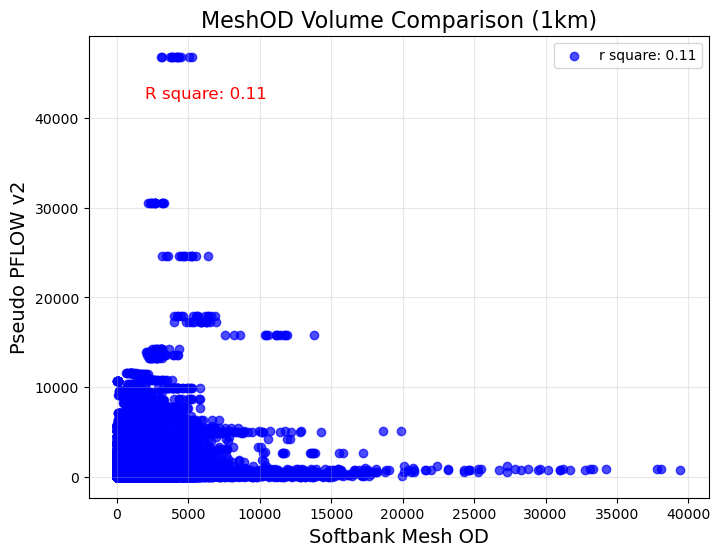

In [18]:
# 提取需要绘图的两列
x = merged_df['total_people']
y = merged_df['volume']

# 计算相关系数
correlation = np.corrcoef(x, y)[0, 1]  # 相关系数矩阵中的第一行第二列
r_square =  x.corr(y) ** 2

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.7, label=f'r square: {r_square:.2f}')
plt.title('MeshOD Volume Comparison (1km)', fontsize=16)
plt.xlabel('Softbank Mesh OD', fontsize=14)
plt.ylabel('Pseudo PFLOW v2', fontsize=14)

# 在图上标注相关系数
plt.text(
    x.min() + (x.max() - x.min()) * 0.05,  # X 坐标，稍微偏移避免重叠
    y.max() - (y.max() - y.min()) * 0.1,  # Y 坐标，靠近顶部
    f'R square: {r_square:.2f}',
    fontsize=12,
    color='red'
)

plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [19]:
# zone_mesh_map = pd.read_csv('/home/owner/Downloads/22.csv', encoding='shift-jis').set_index('基準メッシュ・コード')['都道府県市区町村コード'].to_dict()
zone_mesh_map = pd.read_csv('C://large/Mesh/22.csv', encoding='shift-jis').set_index('基準メッシュ・コード')['都道府県市区町村コード'].to_dict()
# zone_mesh_map

In [20]:
# cityname = pd.read_csv('/home/owner/Downloads/22.csv', encoding='shift-jis').set_index('都道府県市区町村コード')['市区町村名'].to_dict()
cityname = pd.read_csv('C://large/Mesh/22.csv', encoding='shift-jis').set_index('都道府県市区町村コード')['市区町村名'].to_dict()
# cityname

In [21]:
merged_df['origin_city'] = merged_df['origin'].map(zone_mesh_map)
merged_df['destination_city'] = merged_df['destination'].map(zone_mesh_map)
# merged_df2['origin_city'] = merged_df2['origin'].map(zone_mesh_map)
# merged_df2['destination_city'] = merged_df2['destination'].map(zone_mesh_map)
# merged_df2

In [22]:
shizuoka_pseudo['origin_city'] = shizuoka_pseudo['origin'].map(zone_mesh_map)
shizuoka_pseudo['destination_city'] = shizuoka_pseudo['destination'].map(zone_mesh_map)
shizuoka_pseudo = shizuoka_pseudo.dropna()
shizuoka_pseudo['origin_cityname'] = shizuoka_pseudo['origin_city'].map(cityname)
shizuoka_pseudo['destination_cityname'] = shizuoka_pseudo['destination_city'].map(cityname)
shizuoka_pseudo

C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_13340\1948330910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shizuoka_pseudo['origin_cityname'] = shizuoka_pseudo['origin_city'].map(cityname)
C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_13340\1948330910.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shizuoka_pseudo['destination_cityname'] = shizuoka_pseudo['destination_city'].map(cityname)


,origin,destination,volume,origin_city,destination_city,origin_cityname,destination_cityname
77,51377597,51377597,1,22134.0,22134.0,浜松市南区,浜松市南区
78,51377597,51377691,1,22134.0,22134.0,浜松市南区,浜松市南区
79,51377597,52370507,1,22134.0,22134.0,浜松市南区,浜松市南区
80,51377597,52370588,1,22134.0,22131.0,浜松市南区,浜松市中区
81,51377597,52370679,1,22134.0,22211.0,浜松市南区,磐田市
...,...,...,...,...,...,...,...
707498,53390031,52387784,1,22344.0,22215.0,小山町,御殿場市
707499,53390031,52387785,1,22344.0,22215.0,小山町,御殿場市
707500,53390031,53380715,1,22344.0,22344.0,小山町,小山町
707501,53390031,53380739,1,22344.0,22344.0,小山町,小山町


In [23]:
merged_df_city = (
    merged_df.groupby(["origin_city", "destination_city"], as_index=False)  # 分组，并保留列作为 DataFrame
    .agg(
        {'total_people': 'sum',
         'volume': 'sum'}  # 汇总人口列
    ) 
)
merged_df_city

,origin_city,destination_city,total_people,volume
0,22101,22101,5512977.6,4967170
1,22101,22102,527603.6,1596937
2,22101,22103,137045.7,162617
3,22101,22214,7.0,8
4,22102,22101,524653.2,1467437
...,...,...,...,...
228,22461,22137,7.0,13
229,22461,22211,32106.3,3459
230,22461,22213,69003.4,1916
231,22461,22216,79805.3,31321


In [24]:
merged_df_city[merged_df_city['total_people'] > 400000]

,origin_city,destination_city,total_people,volume
0,22101,22101,5512977.6,4967170
1,22101,22102,527603.6,1596937
4,22102,22101,524653.2,1467437
5,22102,22102,5793679.3,6862782
12,22103,22103,5734511.1,3372104
16,22131,22131,4249800.7,3127620
18,22131,22133,593268.9,216237
19,22131,22134,419380.0,403125
22,22132,22132,3996514.4,2201447
28,22133,22131,581838.0,226734


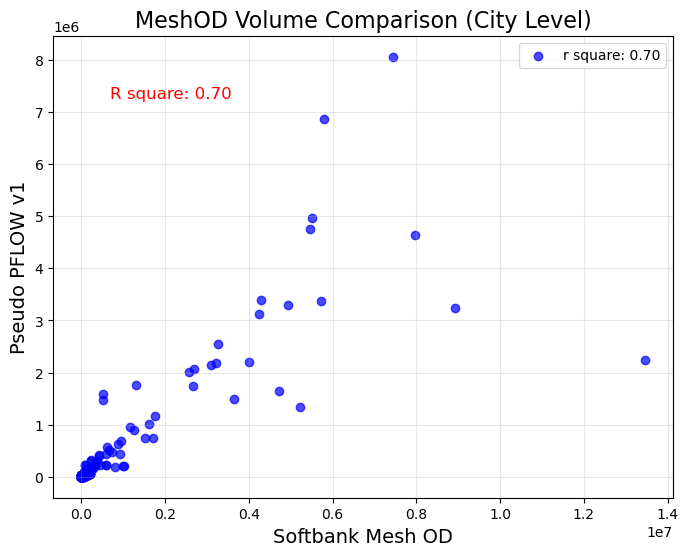

In [25]:
# 提取需要绘图的两列
x = merged_df_city['total_people']
y = merged_df_city['volume']

# 计算相关系数
correlation = np.corrcoef(x, y)[0, 1]  # 相关系数矩阵中的第一行第二列
r_square =  x.corr(y) ** 2

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.7, label=f'r square: {r_square:.2f}')
plt.title('MeshOD Volume Comparison (City Level)', fontsize=16)
plt.xlabel('Softbank Mesh OD', fontsize=14)
plt.ylabel('Pseudo PFLOW v1', fontsize=14)

# 在图上标注相关系数
plt.text(
    x.min() + (x.max() - x.min()) * 0.05,  # X 坐标，稍微偏移避免重叠
    y.max() - (y.max() - y.min()) * 0.1,  # Y 坐标，靠近顶部
    f'R square: {r_square:.2f}',
    fontsize=12,
    color='red'
)

plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [26]:
mape = np.mean(np.abs((merged_df_city['total_people'] - merged_df_city['volume']) / merged_df_city['total_people'])) * 100
mape

84.98072369879775

In [27]:
merged_df_city[(merged_df_city['total_people']>50000) & (merged_df_city['volume']<10000)]

,origin_city,destination_city,total_people,volume
27,22132,22211,120133.2,6763
95,22211,22132,122037.6,8128
106,22212,22424,89499.2,7851
113,22213,22461,73290.5,1920
221,22424,22212,87691.5,8406
230,22461,22213,69003.4,1916
